###  Problema a ser resolvido!

Temos que se atentar a casos de autores que não tenho nenhuma conexão. Código atual só está inserindo pelas arestas, portanto esses casos ainda não estão contemplado.

Um problema similar está acontecendo para os papers. O autor do qual extraímos a informação está sendo contablizado para quando checamos se o paper tem ou não coautor comum, ou seja, todo paper tem coautor comum, que é o próprio autor que estamos pesquisando.
Para resolver esse problema, poderíamos desconsiderar o autor que estamos olhando, porém, o seu nome de citação não está bem definido, não sabemos de fato qual a abreviação(ões) que estão sendo utilizadas para seu nome.

Note que o problema de utilizar os nomes abreviados acontece para todos os autores. Estamos inclusive gerando nós duplicados com o mesmo autor e os conectando.



In [1]:
%matplotlib inline
from scrape_scholar import scrape, scrape_bypass
from flask import Flask
import sqlite3
import pandas as pd
import itertools
import networkx as nx
import requests
from bs4 import BeautifulSoup

In [2]:
# Testando
# papers = scrape('Evandro Parente')
url_author = 'https://scholar.google.com.br/citations?user=kwimDOUAAAAJ&hl=pt-BR&oi=ao'
papers = scrape_bypass(url_author)

<Response [200]>


/home/davi/Dropbox/FGV/EMAp/FDS-Homeworks/scrape_scholar.py:71: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 71 of the file /home/davi/Dropbox/FGV/EMAp/FDS-Homeworks/scrape_scholar.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(r.text)


In [64]:
flat = []
for i in papers:
    for k in i['authors']:
        flat.append([i['title'],k])
flat = pd.DataFrame(flat,columns=['paper','author'])

# Criando a base de dados

In [61]:
schema = """
DROP TABLE IF EXISTS "author";
DROP TABLE IF EXISTS "paper";
DROP TABLE IF EXISTS "author_paper";
CREATE TABLE "author" (
    "id" INTEGER PRIMARY KEY  NOT NULL ,
    "author_name" VARCHAR NOT NULL UNIQUE
);
CREATE TABLE "paper" (
    "id" INTEGER PRIMARY KEY  NOT NULL ,
    "paper_name" VARCHAR NOT NULL UNIQUE
);
CREATE TABLE "author_paper" (
    paper_id VARCHAR,
    author_id VARCHAR,
    FOREIGN KEY(paper_id) REFERENCES paper(id)
    FOREIGN KEY(author_id) REFERENCES author(id)
);
"""

In [62]:
conn = sqlite3.connect('hw1.sqlite',timeout=10)
cursor = conn.cursor()
cursor.executescript(schema)
conn.commit()
conn.close()

In [65]:
# ins_paper_author ="""
# INSERT INTO author_paper (paper_id, author_id) \
#     VALUES (?,?);
# """

# conn = sqlite3.connect('hw1.sqlite',timeout=10)
# for i in papers:
#     pairs = list(itertools.product([i['title']],i['authors']))
#     for pair in pairs:
#         conn.execute(ins_paper_author,pair)
# conn.commit()
# conn.close()

In [67]:
autores =sorted(set([i for sublist in [i['authors'] for i in papers] for i in sublist]))
articles= [i['title'] for i in papers]

In [68]:
ins_author = """
INSERT OR IGNORE INTO author (author_name) VALUES (?);
"""
conn = sqlite3.connect('hw1.sqlite',timeout=10)
for autor in autores:
    conn.execute(ins_author,[autor])
conn.commit()
conn.close()

In [69]:
ins_paper = """
INSERT OR IGNORE INTO paper (paper_name) VALUES (?);
"""
conn = sqlite3.connect('hw1.sqlite',timeout=10)
for paper in articles:
    conn.execute(ins_paper,[paper])
conn.commit()
conn.close()

In [70]:
conn = sqlite3.connect('hw1.sqlite',timeout=10)
paper_ids = []
for row in conn.execute('SELECT * FROM paper'):
    paper_ids.append(row)
    
author_ids = []
for row in conn.execute('SELECT * FROM author'):
    author_ids.append(row)
conn.close()

paper_ids = pd.DataFrame(paper_ids,columns=['paper_id','paper'])

author_ids= pd.DataFrame(author_ids,columns=['author_id','author'])

In [71]:
paper_author = pd.merge(flat,paper_ids,on='paper')
paper_author = pd.merge(paper_author,author_ids,on='author')

In [74]:
ins_paper_author ="""
INSERT INTO author_paper (paper_id, author_id) \
    VALUES (?,?);
"""

conn = sqlite3.connect('hw1.sqlite',timeout=10)
for index,row in paper_author.iterrows():
    conn.execute(ins_paper_author,[row['paper_id'],row['author_id']])
conn.commit()
conn.close()

In [57]:
conn = sqlite3.connect('hw1.sqlite',timeout=10)
conn.close()
# for row in conn.execute('SELECT * FROM paper'):
#     print(row)

In [75]:
query_pair_authors = """
SELECT paper_id,
       a1.author_id AS author1,
       a2.author_id AS author2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (paper_id)
WHERE a1.author_id < a2.author_id;
"""

In [76]:
conn = sqlite3.connect('hw1.sqlite')
edges_authors = []
for row in conn.execute(query_pair_authors):
    edges_authors.append(row)
conn.close()
edges_authors= pd.DataFrame(edges_authors,columns=['paper','author1','author2'])

In [77]:
edges_authors.head()

,paper,author1,author2
0,1,26,9
1,4,26,33
2,4,26,9
3,2,25,9
4,9,25,9


In [78]:
query_pair_papers = """
SELECT author_id,
       a1.paper_id AS paper1,
       a2.paper_id AS paper2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (author_id)
WHERE a1.paper_id < a2.paper_id;
"""

In [79]:
conn = sqlite3.connect('hw1.sqlite')
edges_papers = []
for row in conn.execute(query_pair_papers):
    edges_papers.append(row)
conn.close()
edges_papers = pd.DataFrame(edges_papers,columns=['author','paper1','paper2'])

In [80]:
edges_papers.head()

,author,paper1,paper2
0,26,1,4
1,9,1,10
2,9,1,14
3,9,1,16
4,9,1,17


In [81]:
count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()
count_papers  = edges_papers.groupby(['paper1','paper2']).count().reset_index()

In [82]:
G_authors = nx.Graph()
G_papers = nx.Graph()

In [83]:
for d in count_authors.to_dict('records'):
    G_authors.add_edge(d['author1'],d['author2'],count = d['paper'])
    
for d in count_papers.to_dict('records'):
    G_papers.add_edge(d['paper1'],d['paper2'],count = d['author'])

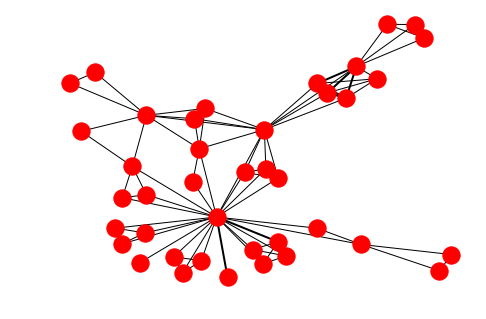

In [85]:
weights = [G_authors[u][v]['count'] for u,v in G_authors.edges]
nx.draw_spring(G_authors,width=weights)

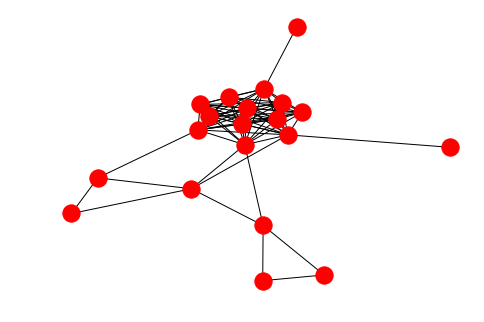

In [86]:
nx.draw_spring(G_papers)

In [87]:
edges_papers

,author,paper1,paper2
0,26,1,4
1,9,1,10
2,9,1,14
3,9,1,16
4,9,1,17
5,9,1,18
6,9,1,19
7,9,1,2
8,9,1,3
9,9,1,4


In [88]:
paper_author

,paper,author,paper_id,author_id
0,An object-oriented framework for finite elemen...,LF Martha,1,26
1,An OOP class organization for materially nonli...,LF Martha,4,26
2,An object-oriented framework for finite elemen...,E Parente Jr,1,9
3,Improvement of semi‐analytical design sensitiv...,E Parente Jr,2,9
4,A hybrid shared/distributed memory parallel ge...,E Parente Jr,3,9
5,An OOP class organization for materially nonli...,E Parente Jr,4,9
6,Optimization of composite catenary risers,E Parente Jr,6,9
7,On evaluation of shape sensitivities of non‐li...,E Parente Jr,9,9
8,Design sensitivity analysis of nonlinear struc...,E Parente Jr,10,9
9,Análise de sensibilidade e otimização de forma...,E Parente Jr,14,9
